# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

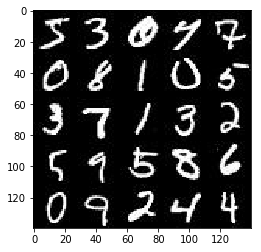

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

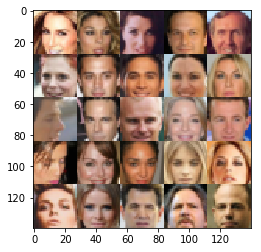

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    print("Image channels: {}".format(image_channels))
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Image channels: 3
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\allxo_000\\Anaconda3\\envs\\tensorflow\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\allxo_000\\Anaconda3\\envs\\tensorflow\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\allxo_000\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\allxo_000\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\allxo_000\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, i

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2, keep_prob = 0.75):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x[1,3]
        x1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 28x28x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 14x14x128

        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)

        # 7x7x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob = 0.75):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        if is_train:
            x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        if is_train:
            x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        if is_train:
            x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x[1,3] now

        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    generator_booster = 2
    print_every = 25
    show_every = 100
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # [-0.5,0.5] => [-1,1]
                batch_images *=2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers (1:2 discriminator/generator run)
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                for boost_i in range(generator_booster):
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...Step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Image channels: 1
Epoch 1/2...Step 25 Discriminator Loss: 1.6929... Generator Loss: 0.7116
Epoch 1/2...Step 50 Discriminator Loss: 1.4475... Generator Loss: 1.1635
Epoch 1/2...Step 75 Discriminator Loss: 1.9510... Generator Loss: 0.6705
Epoch 1/2...Step 100 Discriminator Loss: 1.8306... Generator Loss: 1.0994


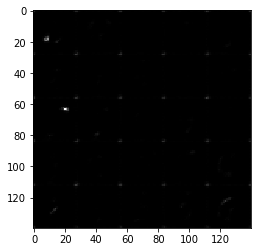

Epoch 1/2...Step 125 Discriminator Loss: 1.5307... Generator Loss: 0.7445
Epoch 1/2...Step 150 Discriminator Loss: 1.8502... Generator Loss: 0.4996
Epoch 1/2...Step 175 Discriminator Loss: 1.5411... Generator Loss: 1.2575
Epoch 1/2...Step 200 Discriminator Loss: 1.5183... Generator Loss: 0.5282


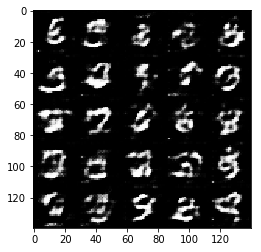

Epoch 1/2...Step 225 Discriminator Loss: 1.3946... Generator Loss: 0.7723
Epoch 1/2...Step 250 Discriminator Loss: 1.5301... Generator Loss: 1.6176
Epoch 1/2...Step 275 Discriminator Loss: 1.7565... Generator Loss: 0.5379
Epoch 1/2...Step 300 Discriminator Loss: 1.5962... Generator Loss: 0.6864


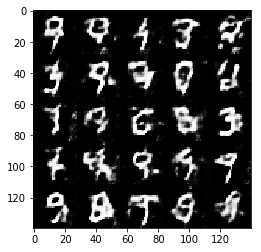

Epoch 1/2...Step 325 Discriminator Loss: 1.4828... Generator Loss: 1.4874
Epoch 1/2...Step 350 Discriminator Loss: 1.5523... Generator Loss: 0.7082
Epoch 1/2...Step 375 Discriminator Loss: 1.3562... Generator Loss: 0.8568
Epoch 1/2...Step 400 Discriminator Loss: 1.4686... Generator Loss: 0.5880


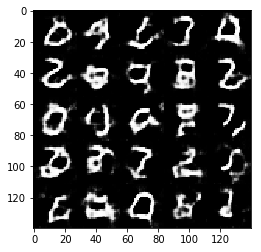

Epoch 1/2...Step 425 Discriminator Loss: 1.4634... Generator Loss: 0.8839
Epoch 1/2...Step 450 Discriminator Loss: 1.3884... Generator Loss: 1.2138
Epoch 1/2...Step 475 Discriminator Loss: 1.3220... Generator Loss: 0.8588
Epoch 1/2...Step 500 Discriminator Loss: 1.6267... Generator Loss: 0.4270


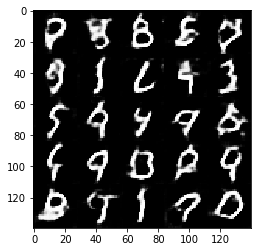

Epoch 1/2...Step 525 Discriminator Loss: 1.5349... Generator Loss: 0.7279
Epoch 1/2...Step 550 Discriminator Loss: 1.3427... Generator Loss: 0.8820
Epoch 1/2...Step 575 Discriminator Loss: 1.4972... Generator Loss: 0.9548
Epoch 1/2...Step 600 Discriminator Loss: 1.5856... Generator Loss: 0.8191


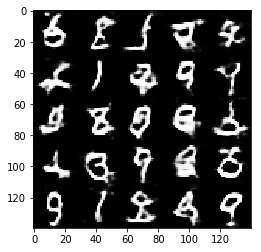

Epoch 1/2...Step 625 Discriminator Loss: 1.5581... Generator Loss: 0.5884
Epoch 1/2...Step 650 Discriminator Loss: 1.3231... Generator Loss: 1.2052
Epoch 1/2...Step 675 Discriminator Loss: 1.6343... Generator Loss: 0.6354
Epoch 1/2...Step 700 Discriminator Loss: 1.3938... Generator Loss: 1.3321


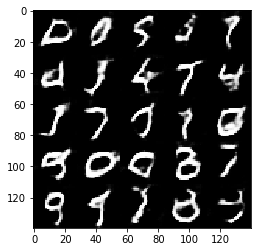

Epoch 1/2...Step 725 Discriminator Loss: 1.4368... Generator Loss: 0.7297
Epoch 1/2...Step 750 Discriminator Loss: 1.3015... Generator Loss: 1.4995
Epoch 1/2...Step 775 Discriminator Loss: 1.3850... Generator Loss: 0.6657
Epoch 1/2...Step 800 Discriminator Loss: 1.6860... Generator Loss: 0.5165


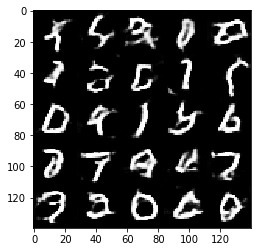

Epoch 1/2...Step 825 Discriminator Loss: 1.2709... Generator Loss: 0.6976
Epoch 1/2...Step 850 Discriminator Loss: 1.3726... Generator Loss: 0.8285
Epoch 1/2...Step 875 Discriminator Loss: 1.2030... Generator Loss: 1.0584
Epoch 1/2...Step 900 Discriminator Loss: 1.4096... Generator Loss: 1.0704


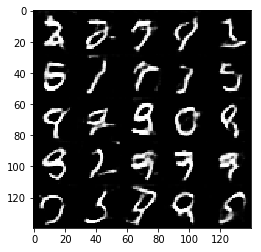

Epoch 1/2...Step 925 Discriminator Loss: 1.3957... Generator Loss: 0.7550
Epoch 1/2...Step 950 Discriminator Loss: 1.3510... Generator Loss: 1.3375
Epoch 1/2...Step 975 Discriminator Loss: 1.2716... Generator Loss: 1.2266
Epoch 1/2...Step 1000 Discriminator Loss: 1.2372... Generator Loss: 0.8131


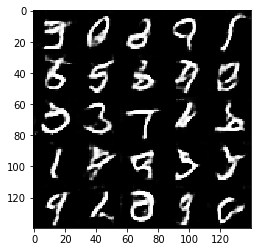

Epoch 1/2...Step 1025 Discriminator Loss: 1.2130... Generator Loss: 1.4242
Epoch 1/2...Step 1050 Discriminator Loss: 1.2497... Generator Loss: 0.8522
Epoch 1/2...Step 1075 Discriminator Loss: 1.2201... Generator Loss: 1.2288
Epoch 1/2...Step 1100 Discriminator Loss: 1.2810... Generator Loss: 0.9796


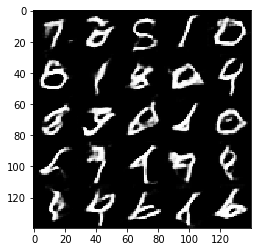

Epoch 1/2...Step 1125 Discriminator Loss: 1.4708... Generator Loss: 0.5128
Epoch 1/2...Step 1150 Discriminator Loss: 1.2418... Generator Loss: 1.2939
Epoch 1/2...Step 1175 Discriminator Loss: 1.3368... Generator Loss: 0.9451
Epoch 1/2...Step 1200 Discriminator Loss: 1.4435... Generator Loss: 1.0613


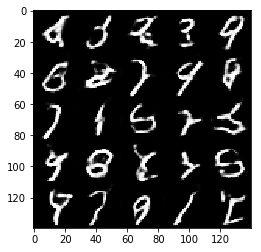

Epoch 1/2...Step 1225 Discriminator Loss: 1.2441... Generator Loss: 0.7481
Epoch 1/2...Step 1250 Discriminator Loss: 1.1646... Generator Loss: 1.0236
Epoch 1/2...Step 1275 Discriminator Loss: 1.2845... Generator Loss: 1.2302
Epoch 1/2...Step 1300 Discriminator Loss: 1.2576... Generator Loss: 0.8267


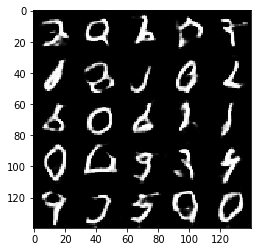

Epoch 1/2...Step 1325 Discriminator Loss: 1.2956... Generator Loss: 0.8015
Epoch 1/2...Step 1350 Discriminator Loss: 1.2058... Generator Loss: 0.7903
Epoch 1/2...Step 1375 Discriminator Loss: 1.3555... Generator Loss: 0.6400
Epoch 1/2...Step 1400 Discriminator Loss: 1.3156... Generator Loss: 1.2174


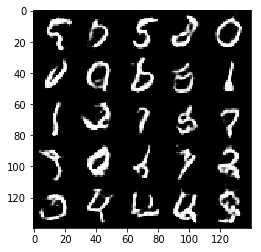

Epoch 1/2...Step 1425 Discriminator Loss: 1.0838... Generator Loss: 1.0694
Epoch 1/2...Step 1450 Discriminator Loss: 1.4235... Generator Loss: 1.3045
Epoch 1/2...Step 1475 Discriminator Loss: 1.6299... Generator Loss: 1.8405
Epoch 1/2...Step 1500 Discriminator Loss: 1.1915... Generator Loss: 1.2223


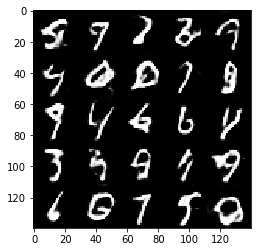

Epoch 1/2...Step 1525 Discriminator Loss: 1.1827... Generator Loss: 1.2176
Epoch 1/2...Step 1550 Discriminator Loss: 1.3565... Generator Loss: 1.1411
Epoch 1/2...Step 1575 Discriminator Loss: 1.1801... Generator Loss: 1.2010
Epoch 1/2...Step 1600 Discriminator Loss: 1.5684... Generator Loss: 0.4924


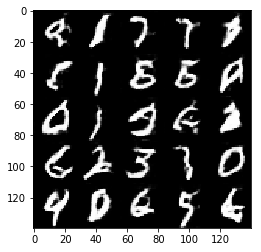

Epoch 1/2...Step 1625 Discriminator Loss: 1.2632... Generator Loss: 0.6826
Epoch 1/2...Step 1650 Discriminator Loss: 1.2534... Generator Loss: 0.8132
Epoch 1/2...Step 1675 Discriminator Loss: 1.1732... Generator Loss: 0.9605
Epoch 1/2...Step 1700 Discriminator Loss: 1.1998... Generator Loss: 0.8794


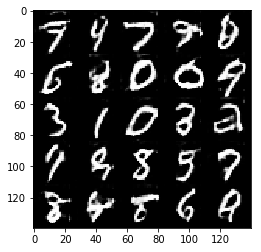

Epoch 1/2...Step 1725 Discriminator Loss: 1.7876... Generator Loss: 0.9320
Epoch 1/2...Step 1750 Discriminator Loss: 1.0000... Generator Loss: 1.4591
Epoch 1/2...Step 1775 Discriminator Loss: 0.7951... Generator Loss: 1.5872
Epoch 1/2...Step 1800 Discriminator Loss: 1.3143... Generator Loss: 1.8384


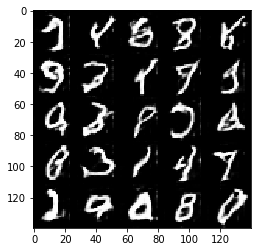

Epoch 1/2...Step 1825 Discriminator Loss: 1.4007... Generator Loss: 0.7958
Epoch 1/2...Step 1850 Discriminator Loss: 1.1049... Generator Loss: 0.8855
Epoch 1/2...Step 1875 Discriminator Loss: 1.2800... Generator Loss: 0.6218
Epoch 2/2...Step 1900 Discriminator Loss: 1.2889... Generator Loss: 1.0729


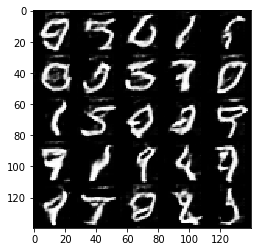

Epoch 2/2...Step 1925 Discriminator Loss: 1.1905... Generator Loss: 0.9509
Epoch 2/2...Step 1950 Discriminator Loss: 1.2880... Generator Loss: 1.0120
Epoch 2/2...Step 1975 Discriminator Loss: 1.2096... Generator Loss: 1.4171
Epoch 2/2...Step 2000 Discriminator Loss: 1.3279... Generator Loss: 1.0606


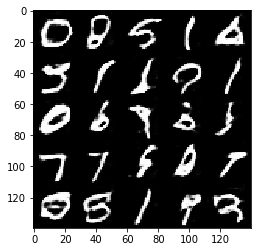

Epoch 2/2...Step 2025 Discriminator Loss: 1.1443... Generator Loss: 1.1621
Epoch 2/2...Step 2050 Discriminator Loss: 1.1424... Generator Loss: 1.2430
Epoch 2/2...Step 2075 Discriminator Loss: 1.1465... Generator Loss: 0.8523
Epoch 2/2...Step 2100 Discriminator Loss: 1.1275... Generator Loss: 2.2572


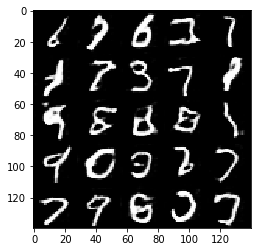

Epoch 2/2...Step 2125 Discriminator Loss: 1.2715... Generator Loss: 1.1236
Epoch 2/2...Step 2150 Discriminator Loss: 1.1340... Generator Loss: 0.8977
Epoch 2/2...Step 2175 Discriminator Loss: 1.2000... Generator Loss: 1.2278
Epoch 2/2...Step 2200 Discriminator Loss: 1.3593... Generator Loss: 2.2620


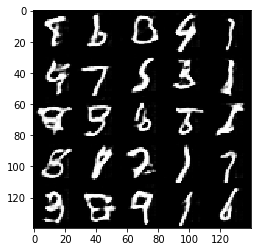

Epoch 2/2...Step 2225 Discriminator Loss: 0.9762... Generator Loss: 1.2171
Epoch 2/2...Step 2250 Discriminator Loss: 1.2091... Generator Loss: 1.1306
Epoch 2/2...Step 2275 Discriminator Loss: 0.9815... Generator Loss: 1.4710
Epoch 2/2...Step 2300 Discriminator Loss: 0.9492... Generator Loss: 1.3762


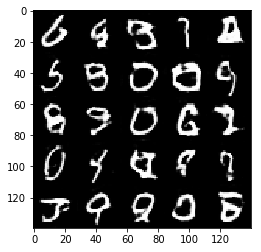

Epoch 2/2...Step 2325 Discriminator Loss: 1.0932... Generator Loss: 0.9625
Epoch 2/2...Step 2350 Discriminator Loss: 0.7982... Generator Loss: 1.5908
Epoch 2/2...Step 2375 Discriminator Loss: 0.9739... Generator Loss: 1.2282
Epoch 2/2...Step 2400 Discriminator Loss: 0.9854... Generator Loss: 1.5225


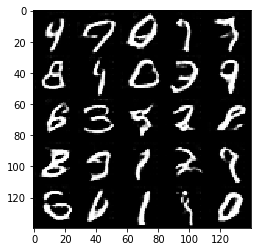

Epoch 2/2...Step 2425 Discriminator Loss: 0.8099... Generator Loss: 1.7669
Epoch 2/2...Step 2450 Discriminator Loss: 1.1047... Generator Loss: 1.2855
Epoch 2/2...Step 2475 Discriminator Loss: 0.7817... Generator Loss: 1.7630
Epoch 2/2...Step 2500 Discriminator Loss: 1.1380... Generator Loss: 1.7319


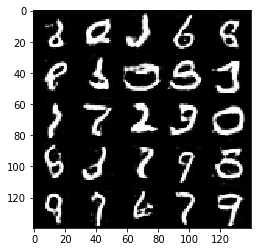

Epoch 2/2...Step 2525 Discriminator Loss: 1.1882... Generator Loss: 1.2960
Epoch 2/2...Step 2550 Discriminator Loss: 1.0600... Generator Loss: 1.1323
Epoch 2/2...Step 2575 Discriminator Loss: 0.9175... Generator Loss: 1.7687
Epoch 2/2...Step 2600 Discriminator Loss: 1.1032... Generator Loss: 1.3868


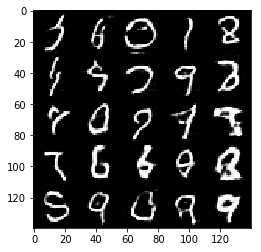

Epoch 2/2...Step 2625 Discriminator Loss: 0.9960... Generator Loss: 1.4547
Epoch 2/2...Step 2650 Discriminator Loss: 1.0130... Generator Loss: 1.4304
Epoch 2/2...Step 2675 Discriminator Loss: 1.5062... Generator Loss: 0.7980
Epoch 2/2...Step 2700 Discriminator Loss: 1.3448... Generator Loss: 0.8111


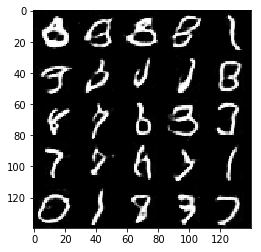

Epoch 2/2...Step 2725 Discriminator Loss: 1.1825... Generator Loss: 0.9101
Epoch 2/2...Step 2750 Discriminator Loss: 1.1632... Generator Loss: 0.8464
Epoch 2/2...Step 2775 Discriminator Loss: 0.9697... Generator Loss: 1.4205
Epoch 2/2...Step 2800 Discriminator Loss: 1.1215... Generator Loss: 1.4160


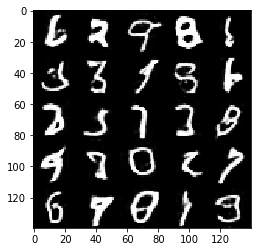

Epoch 2/2...Step 2825 Discriminator Loss: 0.9815... Generator Loss: 1.1725
Epoch 2/2...Step 2850 Discriminator Loss: 0.9286... Generator Loss: 1.3568
Epoch 2/2...Step 2875 Discriminator Loss: 1.0563... Generator Loss: 1.1965
Epoch 2/2...Step 2900 Discriminator Loss: 1.1780... Generator Loss: 0.9557


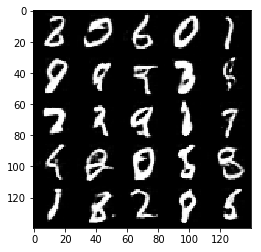

Epoch 2/2...Step 2925 Discriminator Loss: 2.1833... Generator Loss: 3.1990
Epoch 2/2...Step 2950 Discriminator Loss: 1.1569... Generator Loss: 1.3148
Epoch 2/2...Step 2975 Discriminator Loss: 0.8691... Generator Loss: 1.7852
Epoch 2/2...Step 3000 Discriminator Loss: 1.1742... Generator Loss: 1.1942


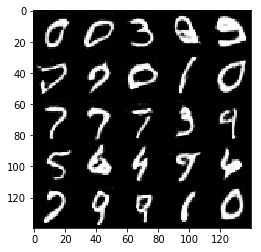

Epoch 2/2...Step 3025 Discriminator Loss: 0.8575... Generator Loss: 1.5476
Epoch 2/2...Step 3050 Discriminator Loss: 0.9455... Generator Loss: 1.0511
Epoch 2/2...Step 3075 Discriminator Loss: 1.0237... Generator Loss: 0.8023
Epoch 2/2...Step 3100 Discriminator Loss: 0.9449... Generator Loss: 1.1772


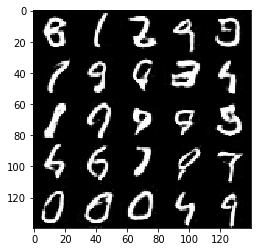

Epoch 2/2...Step 3125 Discriminator Loss: 0.9385... Generator Loss: 1.6923
Epoch 2/2...Step 3150 Discriminator Loss: 1.1628... Generator Loss: 1.0046
Epoch 2/2...Step 3175 Discriminator Loss: 1.2516... Generator Loss: 2.2683
Epoch 2/2...Step 3200 Discriminator Loss: 0.9475... Generator Loss: 0.7912


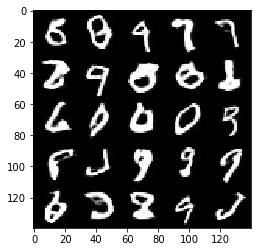

Epoch 2/2...Step 3225 Discriminator Loss: 0.8819... Generator Loss: 1.6638
Epoch 2/2...Step 3250 Discriminator Loss: 0.8787... Generator Loss: 1.7974
Epoch 2/2...Step 3275 Discriminator Loss: 0.9663... Generator Loss: 1.0137
Epoch 2/2...Step 3300 Discriminator Loss: 1.1048... Generator Loss: 1.6752


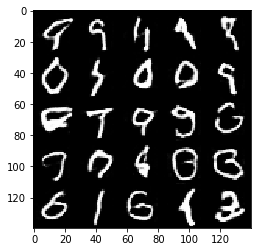

Epoch 2/2...Step 3325 Discriminator Loss: 0.9426... Generator Loss: 1.4246
Epoch 2/2...Step 3350 Discriminator Loss: 0.9784... Generator Loss: 1.2190
Epoch 2/2...Step 3375 Discriminator Loss: 0.8359... Generator Loss: 1.5517
Epoch 2/2...Step 3400 Discriminator Loss: 1.2081... Generator Loss: 0.9317


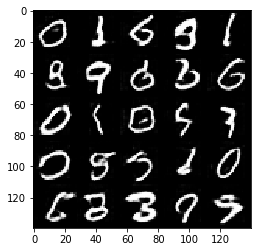

Epoch 2/2...Step 3425 Discriminator Loss: 0.7180... Generator Loss: 1.7624
Epoch 2/2...Step 3450 Discriminator Loss: 0.8850... Generator Loss: 0.9008
Epoch 2/2...Step 3475 Discriminator Loss: 0.9450... Generator Loss: 1.5739
Epoch 2/2...Step 3500 Discriminator Loss: 0.8673... Generator Loss: 1.5145


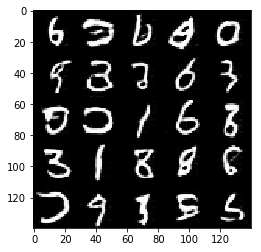

Epoch 2/2...Step 3525 Discriminator Loss: 0.8600... Generator Loss: 1.8949
Epoch 2/2...Step 3550 Discriminator Loss: 0.7765... Generator Loss: 1.7835
Epoch 2/2...Step 3575 Discriminator Loss: 0.7480... Generator Loss: 2.0393
Epoch 2/2...Step 3600 Discriminator Loss: 0.8981... Generator Loss: 1.7294


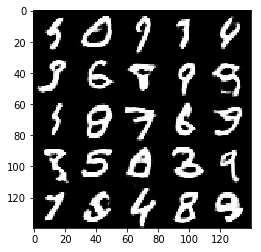

Epoch 2/2...Step 3625 Discriminator Loss: 1.1109... Generator Loss: 1.3870
Epoch 2/2...Step 3650 Discriminator Loss: 0.8178... Generator Loss: 1.9898
Epoch 2/2...Step 3675 Discriminator Loss: 0.8128... Generator Loss: 1.5499
Epoch 2/2...Step 3700 Discriminator Loss: 1.2480... Generator Loss: 1.3054


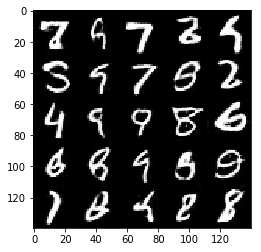

Epoch 2/2...Step 3725 Discriminator Loss: 1.0849... Generator Loss: 1.1482
Epoch 2/2...Step 3750 Discriminator Loss: 1.2297... Generator Loss: 1.0357


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Image channels: 3
Epoch 1/1...Step 25 Discriminator Loss: 1.1018... Generator Loss: 1.7855
Epoch 1/1...Step 50 Discriminator Loss: 1.0043... Generator Loss: 1.6903
Epoch 1/1...Step 75 Discriminator Loss: 0.5861... Generator Loss: 1.8920
Epoch 1/1...Step 100 Discriminator Loss: 0.5656... Generator Loss: 2.7363


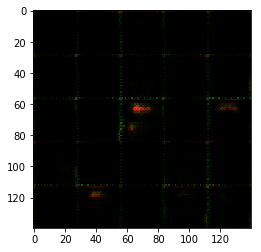

Epoch 1/1...Step 125 Discriminator Loss: 0.5239... Generator Loss: 3.2419
Epoch 1/1...Step 150 Discriminator Loss: 0.8720... Generator Loss: 1.4553
Epoch 1/1...Step 175 Discriminator Loss: 0.8095... Generator Loss: 3.4063
Epoch 1/1...Step 200 Discriminator Loss: 1.0382... Generator Loss: 1.2833


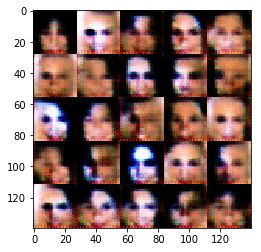

Epoch 1/1...Step 225 Discriminator Loss: 0.7837... Generator Loss: 2.0576
Epoch 1/1...Step 250 Discriminator Loss: 0.9087... Generator Loss: 1.6001
Epoch 1/1...Step 275 Discriminator Loss: 0.6362... Generator Loss: 2.9350
Epoch 1/1...Step 300 Discriminator Loss: 0.8556... Generator Loss: 1.2776


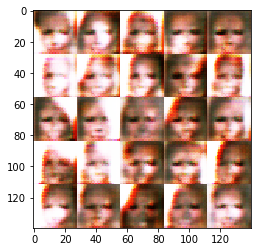

Epoch 1/1...Step 325 Discriminator Loss: 1.2197... Generator Loss: 0.9173
Epoch 1/1...Step 350 Discriminator Loss: 1.4134... Generator Loss: 0.7760
Epoch 1/1...Step 375 Discriminator Loss: 1.0294... Generator Loss: 1.2594
Epoch 1/1...Step 400 Discriminator Loss: 2.1664... Generator Loss: 0.2949


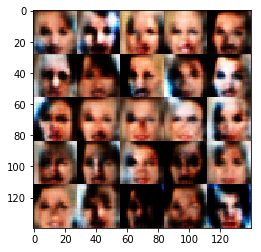

Epoch 1/1...Step 425 Discriminator Loss: 1.1663... Generator Loss: 1.0400
Epoch 1/1...Step 450 Discriminator Loss: 1.4870... Generator Loss: 1.2725
Epoch 1/1...Step 475 Discriminator Loss: 1.4306... Generator Loss: 0.8811
Epoch 1/1...Step 500 Discriminator Loss: 1.4147... Generator Loss: 1.1098


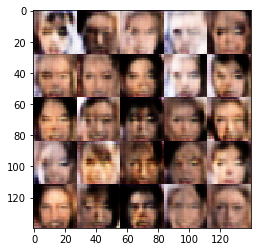

Epoch 1/1...Step 525 Discriminator Loss: 2.3430... Generator Loss: 0.2968
Epoch 1/1...Step 550 Discriminator Loss: 1.4872... Generator Loss: 1.3082
Epoch 1/1...Step 575 Discriminator Loss: 1.3115... Generator Loss: 1.1233
Epoch 1/1...Step 600 Discriminator Loss: 1.4995... Generator Loss: 0.8180


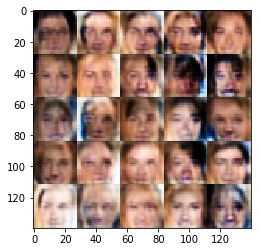

Epoch 1/1...Step 625 Discriminator Loss: 1.2841... Generator Loss: 0.7635
Epoch 1/1...Step 650 Discriminator Loss: 1.4717... Generator Loss: 0.8037
Epoch 1/1...Step 675 Discriminator Loss: 1.8323... Generator Loss: 0.8297
Epoch 1/1...Step 700 Discriminator Loss: 1.6363... Generator Loss: 0.8385


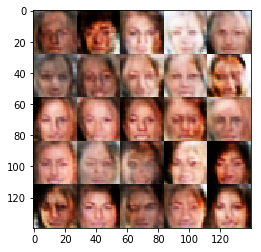

Epoch 1/1...Step 725 Discriminator Loss: 1.4360... Generator Loss: 0.8552
Epoch 1/1...Step 750 Discriminator Loss: 1.3493... Generator Loss: 1.0118
Epoch 1/1...Step 775 Discriminator Loss: 1.3327... Generator Loss: 0.8879
Epoch 1/1...Step 800 Discriminator Loss: 1.5136... Generator Loss: 0.6748


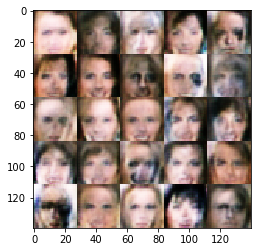

Epoch 1/1...Step 825 Discriminator Loss: 1.8706... Generator Loss: 0.8880
Epoch 1/1...Step 850 Discriminator Loss: 1.5244... Generator Loss: 0.7000
Epoch 1/1...Step 875 Discriminator Loss: 1.5710... Generator Loss: 0.6711
Epoch 1/1...Step 900 Discriminator Loss: 1.9960... Generator Loss: 0.5832


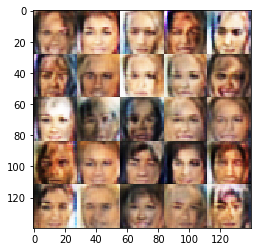

Epoch 1/1...Step 925 Discriminator Loss: 1.6645... Generator Loss: 0.5970
Epoch 1/1...Step 950 Discriminator Loss: 1.4154... Generator Loss: 0.8054
Epoch 1/1...Step 975 Discriminator Loss: 1.6096... Generator Loss: 0.6324
Epoch 1/1...Step 1000 Discriminator Loss: 1.4754... Generator Loss: 0.8894


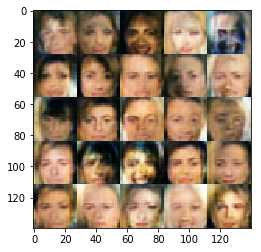

Epoch 1/1...Step 1025 Discriminator Loss: 1.6486... Generator Loss: 0.8653
Epoch 1/1...Step 1050 Discriminator Loss: 1.3038... Generator Loss: 0.9449
Epoch 1/1...Step 1075 Discriminator Loss: 1.5505... Generator Loss: 0.6940
Epoch 1/1...Step 1100 Discriminator Loss: 1.4041... Generator Loss: 0.8775


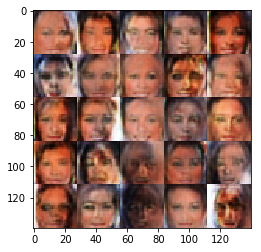

Epoch 1/1...Step 1125 Discriminator Loss: 1.4082... Generator Loss: 0.8435
Epoch 1/1...Step 1150 Discriminator Loss: 1.4166... Generator Loss: 0.8082
Epoch 1/1...Step 1175 Discriminator Loss: 1.4663... Generator Loss: 0.7398
Epoch 1/1...Step 1200 Discriminator Loss: 1.4698... Generator Loss: 0.7684


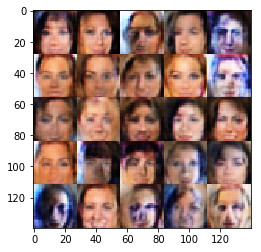

Epoch 1/1...Step 1225 Discriminator Loss: 1.4149... Generator Loss: 0.7079
Epoch 1/1...Step 1250 Discriminator Loss: 1.4851... Generator Loss: 0.6572
Epoch 1/1...Step 1275 Discriminator Loss: 1.5465... Generator Loss: 0.7626
Epoch 1/1...Step 1300 Discriminator Loss: 1.3790... Generator Loss: 0.7243


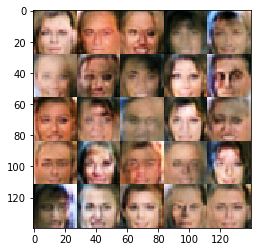

Epoch 1/1...Step 1325 Discriminator Loss: 1.6087... Generator Loss: 0.7064
Epoch 1/1...Step 1350 Discriminator Loss: 1.4204... Generator Loss: 0.6542
Epoch 1/1...Step 1375 Discriminator Loss: 1.4929... Generator Loss: 0.6340
Epoch 1/1...Step 1400 Discriminator Loss: 1.7235... Generator Loss: 0.8276


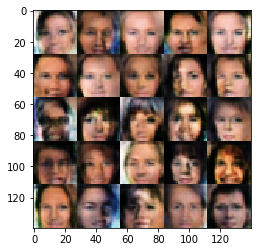

Epoch 1/1...Step 1425 Discriminator Loss: 1.5622... Generator Loss: 0.8811
Epoch 1/1...Step 1450 Discriminator Loss: 1.5314... Generator Loss: 0.7606
Epoch 1/1...Step 1475 Discriminator Loss: 1.6671... Generator Loss: 0.8736
Epoch 1/1...Step 1500 Discriminator Loss: 1.3804... Generator Loss: 0.8528


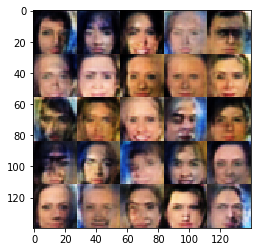

Epoch 1/1...Step 1525 Discriminator Loss: 1.6340... Generator Loss: 0.6079
Epoch 1/1...Step 1550 Discriminator Loss: 1.4685... Generator Loss: 0.7174
Epoch 1/1...Step 1575 Discriminator Loss: 1.2857... Generator Loss: 0.8207
Epoch 1/1...Step 1600 Discriminator Loss: 1.4484... Generator Loss: 0.6894


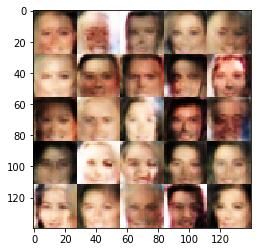

Epoch 1/1...Step 1625 Discriminator Loss: 1.5600... Generator Loss: 0.7011
Epoch 1/1...Step 1650 Discriminator Loss: 1.4046... Generator Loss: 0.7795
Epoch 1/1...Step 1675 Discriminator Loss: 1.6317... Generator Loss: 0.8186
Epoch 1/1...Step 1700 Discriminator Loss: 1.4355... Generator Loss: 0.6905


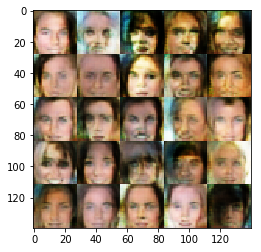

Epoch 1/1...Step 1725 Discriminator Loss: 1.4265... Generator Loss: 0.7533
Epoch 1/1...Step 1750 Discriminator Loss: 1.5715... Generator Loss: 0.7765
Epoch 1/1...Step 1775 Discriminator Loss: 1.5216... Generator Loss: 0.7253
Epoch 1/1...Step 1800 Discriminator Loss: 1.5526... Generator Loss: 0.7090


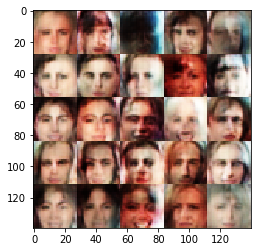

Epoch 1/1...Step 1825 Discriminator Loss: 1.4704... Generator Loss: 0.7576
Epoch 1/1...Step 1850 Discriminator Loss: 1.3936... Generator Loss: 0.7888
Epoch 1/1...Step 1875 Discriminator Loss: 1.4020... Generator Loss: 0.7657
Epoch 1/1...Step 1900 Discriminator Loss: 1.5258... Generator Loss: 0.6950


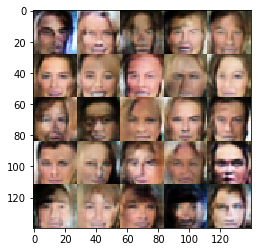

Epoch 1/1...Step 1925 Discriminator Loss: 1.5906... Generator Loss: 0.6188
Epoch 1/1...Step 1950 Discriminator Loss: 1.4897... Generator Loss: 0.7074
Epoch 1/1...Step 1975 Discriminator Loss: 1.4232... Generator Loss: 0.7370
Epoch 1/1...Step 2000 Discriminator Loss: 1.4586... Generator Loss: 0.7794


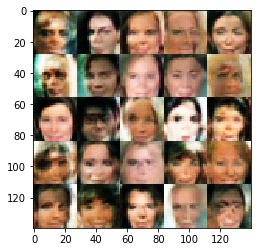

Epoch 1/1...Step 2025 Discriminator Loss: 1.4911... Generator Loss: 0.8738
Epoch 1/1...Step 2050 Discriminator Loss: 1.5411... Generator Loss: 0.7057
Epoch 1/1...Step 2075 Discriminator Loss: 1.5158... Generator Loss: 0.8070
Epoch 1/1...Step 2100 Discriminator Loss: 1.5480... Generator Loss: 0.7022


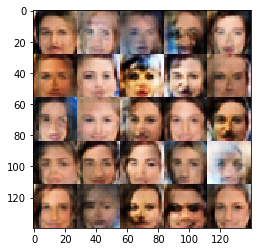

Epoch 1/1...Step 2125 Discriminator Loss: 1.4166... Generator Loss: 0.7050
Epoch 1/1...Step 2150 Discriminator Loss: 1.5600... Generator Loss: 0.7597
Epoch 1/1...Step 2175 Discriminator Loss: 1.5151... Generator Loss: 0.7496
Epoch 1/1...Step 2200 Discriminator Loss: 1.4750... Generator Loss: 0.8116


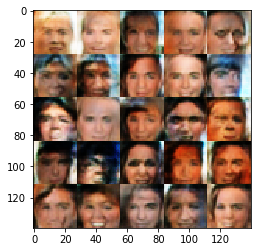

Epoch 1/1...Step 2225 Discriminator Loss: 1.4419... Generator Loss: 0.8029
Epoch 1/1...Step 2250 Discriminator Loss: 1.5324... Generator Loss: 0.7221
Epoch 1/1...Step 2275 Discriminator Loss: 1.5673... Generator Loss: 0.5877
Epoch 1/1...Step 2300 Discriminator Loss: 1.3306... Generator Loss: 0.7863


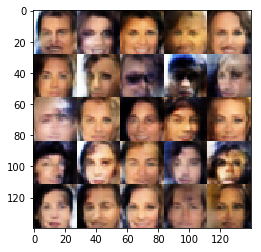

Epoch 1/1...Step 2325 Discriminator Loss: 1.5660... Generator Loss: 0.7563
Epoch 1/1...Step 2350 Discriminator Loss: 1.5973... Generator Loss: 0.6599
Epoch 1/1...Step 2375 Discriminator Loss: 1.5431... Generator Loss: 0.6449
Epoch 1/1...Step 2400 Discriminator Loss: 1.4719... Generator Loss: 0.8384


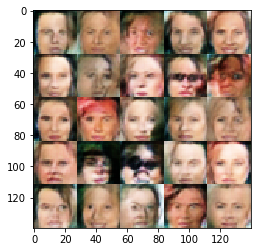

Epoch 1/1...Step 2425 Discriminator Loss: 1.4646... Generator Loss: 0.8633
Epoch 1/1...Step 2450 Discriminator Loss: 1.4648... Generator Loss: 0.6890
Epoch 1/1...Step 2475 Discriminator Loss: 1.3959... Generator Loss: 0.8182
Epoch 1/1...Step 2500 Discriminator Loss: 1.4723... Generator Loss: 0.7801


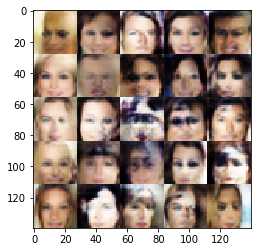

Epoch 1/1...Step 2525 Discriminator Loss: 1.5210... Generator Loss: 0.7949
Epoch 1/1...Step 2550 Discriminator Loss: 1.4645... Generator Loss: 0.7429
Epoch 1/1...Step 2575 Discriminator Loss: 1.4383... Generator Loss: 0.7538
Epoch 1/1...Step 2600 Discriminator Loss: 1.4850... Generator Loss: 0.7382


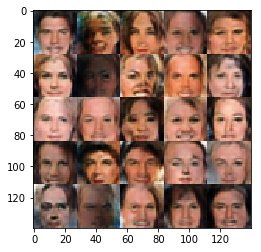

Epoch 1/1...Step 2625 Discriminator Loss: 1.4519... Generator Loss: 0.7744
Epoch 1/1...Step 2650 Discriminator Loss: 1.4874... Generator Loss: 0.7672
Epoch 1/1...Step 2675 Discriminator Loss: 1.4743... Generator Loss: 0.8180
Epoch 1/1...Step 2700 Discriminator Loss: 1.4261... Generator Loss: 0.6875


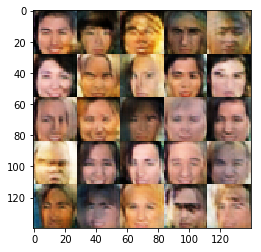

Epoch 1/1...Step 2725 Discriminator Loss: 1.4457... Generator Loss: 0.7513
Epoch 1/1...Step 2750 Discriminator Loss: 1.4896... Generator Loss: 0.7337
Epoch 1/1...Step 2775 Discriminator Loss: 1.4154... Generator Loss: 0.6511
Epoch 1/1...Step 2800 Discriminator Loss: 1.5019... Generator Loss: 0.7448


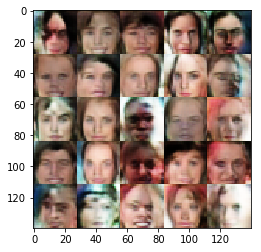

Epoch 1/1...Step 2825 Discriminator Loss: 1.5191... Generator Loss: 0.7800
Epoch 1/1...Step 2850 Discriminator Loss: 1.5352... Generator Loss: 0.5851
Epoch 1/1...Step 2875 Discriminator Loss: 1.5377... Generator Loss: 0.6495
Epoch 1/1...Step 2900 Discriminator Loss: 1.4754... Generator Loss: 0.6938


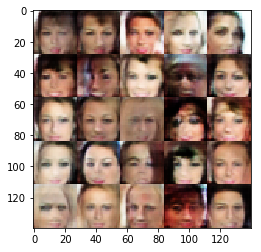

Epoch 1/1...Step 2925 Discriminator Loss: 1.4034... Generator Loss: 0.8799
Epoch 1/1...Step 2950 Discriminator Loss: 1.3837... Generator Loss: 0.7878
Epoch 1/1...Step 2975 Discriminator Loss: 1.5085... Generator Loss: 0.6386
Epoch 1/1...Step 3000 Discriminator Loss: 1.4646... Generator Loss: 0.6865


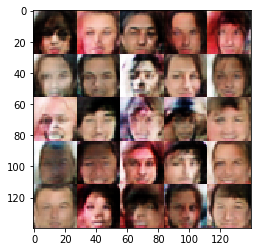

Epoch 1/1...Step 3025 Discriminator Loss: 1.4412... Generator Loss: 0.7372
Epoch 1/1...Step 3050 Discriminator Loss: 1.3539... Generator Loss: 0.8063
Epoch 1/1...Step 3075 Discriminator Loss: 1.5254... Generator Loss: 0.6646
Epoch 1/1...Step 3100 Discriminator Loss: 1.5556... Generator Loss: 0.7179


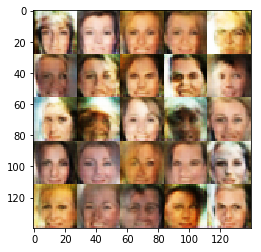

Epoch 1/1...Step 3125 Discriminator Loss: 1.5530... Generator Loss: 0.7014
Epoch 1/1...Step 3150 Discriminator Loss: 1.5788... Generator Loss: 0.8500
Epoch 1/1...Step 3175 Discriminator Loss: 1.4194... Generator Loss: 0.8220
Epoch 1/1...Step 3200 Discriminator Loss: 1.5756... Generator Loss: 0.7078


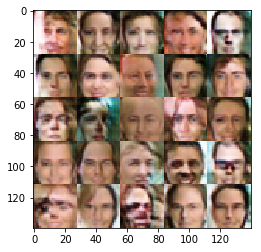

Epoch 1/1...Step 3225 Discriminator Loss: 1.4974... Generator Loss: 0.7582
Epoch 1/1...Step 3250 Discriminator Loss: 1.6556... Generator Loss: 0.6262
Epoch 1/1...Step 3275 Discriminator Loss: 1.5372... Generator Loss: 0.6509
Epoch 1/1...Step 3300 Discriminator Loss: 1.4547... Generator Loss: 0.7994


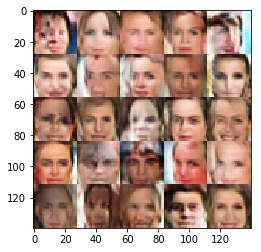

Epoch 1/1...Step 3325 Discriminator Loss: 1.5261... Generator Loss: 0.6685
Epoch 1/1...Step 3350 Discriminator Loss: 1.5903... Generator Loss: 0.5930
Epoch 1/1...Step 3375 Discriminator Loss: 1.5228... Generator Loss: 0.7124
Epoch 1/1...Step 3400 Discriminator Loss: 1.3809... Generator Loss: 0.8088


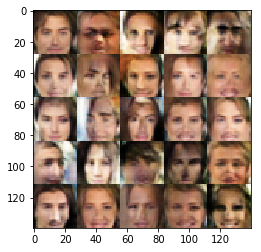

Epoch 1/1...Step 3425 Discriminator Loss: 1.4585... Generator Loss: 0.7479
Epoch 1/1...Step 3450 Discriminator Loss: 1.4785... Generator Loss: 0.7524
Epoch 1/1...Step 3475 Discriminator Loss: 1.5052... Generator Loss: 0.7241
Epoch 1/1...Step 3500 Discriminator Loss: 1.3929... Generator Loss: 0.7361


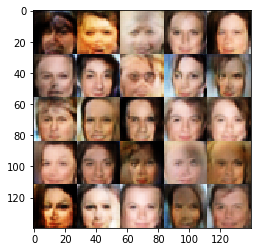

Epoch 1/1...Step 3525 Discriminator Loss: 1.3917... Generator Loss: 0.8350
Epoch 1/1...Step 3550 Discriminator Loss: 1.6611... Generator Loss: 0.6552
Epoch 1/1...Step 3575 Discriminator Loss: 1.4073... Generator Loss: 0.7203
Epoch 1/1...Step 3600 Discriminator Loss: 1.5128... Generator Loss: 0.7363


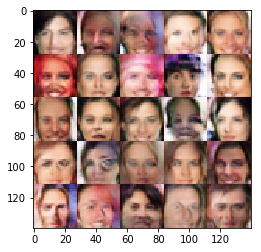

Epoch 1/1...Step 3625 Discriminator Loss: 1.4715... Generator Loss: 0.7623
Epoch 1/1...Step 3650 Discriminator Loss: 1.3973... Generator Loss: 0.7207
Epoch 1/1...Step 3675 Discriminator Loss: 1.3624... Generator Loss: 0.8045
Epoch 1/1...Step 3700 Discriminator Loss: 1.3789... Generator Loss: 0.8231


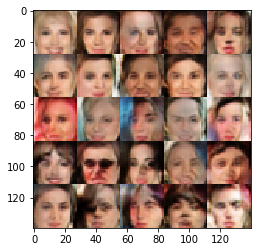

Epoch 1/1...Step 3725 Discriminator Loss: 1.5005... Generator Loss: 0.8003
Epoch 1/1...Step 3750 Discriminator Loss: 1.4760... Generator Loss: 0.7516
Epoch 1/1...Step 3775 Discriminator Loss: 1.5341... Generator Loss: 0.7107
Epoch 1/1...Step 3800 Discriminator Loss: 1.3646... Generator Loss: 0.8678


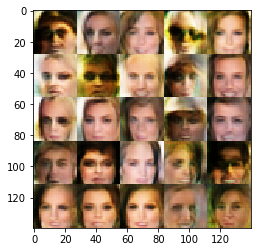

Epoch 1/1...Step 3825 Discriminator Loss: 1.4783... Generator Loss: 0.7521
Epoch 1/1...Step 3850 Discriminator Loss: 1.4507... Generator Loss: 0.8027
Epoch 1/1...Step 3875 Discriminator Loss: 1.4191... Generator Loss: 0.6643
Epoch 1/1...Step 3900 Discriminator Loss: 1.5294... Generator Loss: 0.7663


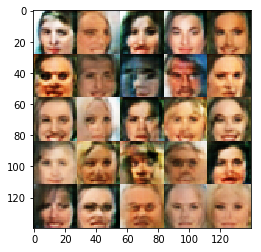

Epoch 1/1...Step 3925 Discriminator Loss: 1.5163... Generator Loss: 0.7583
Epoch 1/1...Step 3950 Discriminator Loss: 1.4567... Generator Loss: 0.6820
Epoch 1/1...Step 3975 Discriminator Loss: 1.3743... Generator Loss: 0.7494
Epoch 1/1...Step 4000 Discriminator Loss: 1.3887... Generator Loss: 0.6920


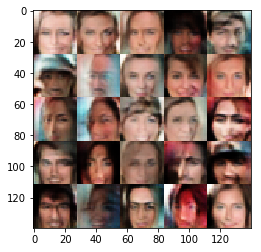

Epoch 1/1...Step 4025 Discriminator Loss: 1.5043... Generator Loss: 0.8313
Epoch 1/1...Step 4050 Discriminator Loss: 1.6171... Generator Loss: 0.6436
Epoch 1/1...Step 4075 Discriminator Loss: 1.4361... Generator Loss: 0.6839
Epoch 1/1...Step 4100 Discriminator Loss: 1.4449... Generator Loss: 0.7211


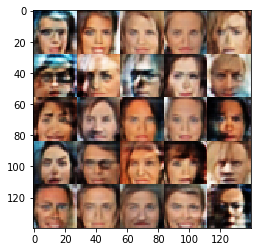

Epoch 1/1...Step 4125 Discriminator Loss: 1.4536... Generator Loss: 0.7974
Epoch 1/1...Step 4150 Discriminator Loss: 1.4641... Generator Loss: 0.8267
Epoch 1/1...Step 4175 Discriminator Loss: 1.3741... Generator Loss: 0.6897
Epoch 1/1...Step 4200 Discriminator Loss: 1.4467... Generator Loss: 0.6700


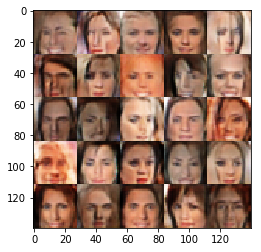

Epoch 1/1...Step 4225 Discriminator Loss: 1.5167... Generator Loss: 0.7634
Epoch 1/1...Step 4250 Discriminator Loss: 1.3734... Generator Loss: 0.9503
Epoch 1/1...Step 4275 Discriminator Loss: 1.4247... Generator Loss: 0.7007
Epoch 1/1...Step 4300 Discriminator Loss: 1.4025... Generator Loss: 0.7359


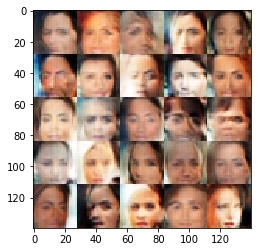

Epoch 1/1...Step 4325 Discriminator Loss: 1.5233... Generator Loss: 0.5870
Epoch 1/1...Step 4350 Discriminator Loss: 1.4888... Generator Loss: 0.7180
Epoch 1/1...Step 4375 Discriminator Loss: 1.4271... Generator Loss: 0.6980
Epoch 1/1...Step 4400 Discriminator Loss: 1.4940... Generator Loss: 0.7291


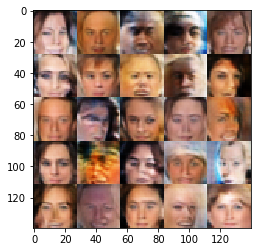

Epoch 1/1...Step 4425 Discriminator Loss: 1.4091... Generator Loss: 0.7269
Epoch 1/1...Step 4450 Discriminator Loss: 1.5224... Generator Loss: 0.7169
Epoch 1/1...Step 4475 Discriminator Loss: 1.3778... Generator Loss: 0.7522
Epoch 1/1...Step 4500 Discriminator Loss: 1.3949... Generator Loss: 0.7885


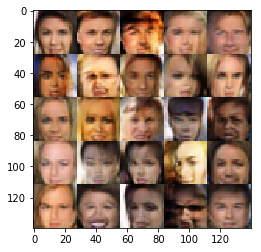

Epoch 1/1...Step 4525 Discriminator Loss: 1.3809... Generator Loss: 0.9300
Epoch 1/1...Step 4550 Discriminator Loss: 1.3962... Generator Loss: 0.7601
Epoch 1/1...Step 4575 Discriminator Loss: 1.3878... Generator Loss: 0.6929
Epoch 1/1...Step 4600 Discriminator Loss: 1.2823... Generator Loss: 1.1422


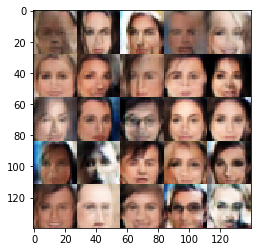

Epoch 1/1...Step 4625 Discriminator Loss: 1.4464... Generator Loss: 0.7417
Epoch 1/1...Step 4650 Discriminator Loss: 1.3764... Generator Loss: 0.7841
Epoch 1/1...Step 4675 Discriminator Loss: 1.4400... Generator Loss: 0.7382
Epoch 1/1...Step 4700 Discriminator Loss: 1.5996... Generator Loss: 0.7036


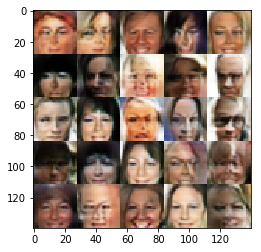

Epoch 1/1...Step 4725 Discriminator Loss: 1.4849... Generator Loss: 0.8084
Epoch 1/1...Step 4750 Discriminator Loss: 1.4132... Generator Loss: 0.8047
Epoch 1/1...Step 4775 Discriminator Loss: 1.4810... Generator Loss: 0.6935
Epoch 1/1...Step 4800 Discriminator Loss: 1.3503... Generator Loss: 0.7413


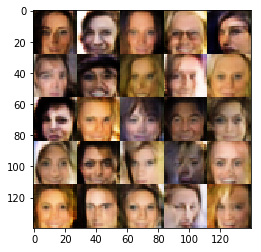

Epoch 1/1...Step 4825 Discriminator Loss: 1.5139... Generator Loss: 0.6876
Epoch 1/1...Step 4850 Discriminator Loss: 1.4251... Generator Loss: 0.8353
Epoch 1/1...Step 4875 Discriminator Loss: 1.5571... Generator Loss: 0.8204
Epoch 1/1...Step 4900 Discriminator Loss: 1.4493... Generator Loss: 0.7674


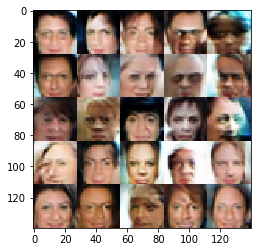

Epoch 1/1...Step 4925 Discriminator Loss: 1.3530... Generator Loss: 0.8272
Epoch 1/1...Step 4950 Discriminator Loss: 1.4656... Generator Loss: 0.7144
Epoch 1/1...Step 4975 Discriminator Loss: 1.5260... Generator Loss: 0.7001
Epoch 1/1...Step 5000 Discriminator Loss: 1.5074... Generator Loss: 0.7256


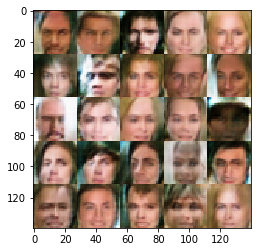

Epoch 1/1...Step 5025 Discriminator Loss: 1.4931... Generator Loss: 0.7046
Epoch 1/1...Step 5050 Discriminator Loss: 1.5233... Generator Loss: 0.7251
Epoch 1/1...Step 5075 Discriminator Loss: 1.4568... Generator Loss: 0.7804
Epoch 1/1...Step 5100 Discriminator Loss: 1.4074... Generator Loss: 0.7713


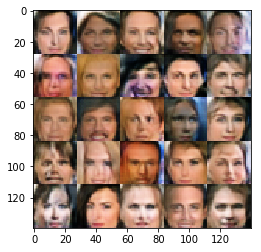

Epoch 1/1...Step 5125 Discriminator Loss: 1.4520... Generator Loss: 0.8071
Epoch 1/1...Step 5150 Discriminator Loss: 1.4513... Generator Loss: 0.6952
Epoch 1/1...Step 5175 Discriminator Loss: 1.4769... Generator Loss: 0.6366
Epoch 1/1...Step 5200 Discriminator Loss: 1.3429... Generator Loss: 0.8576


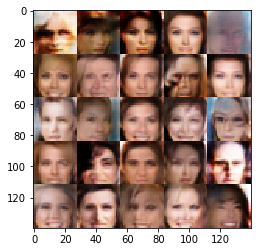

Epoch 1/1...Step 5225 Discriminator Loss: 1.4504... Generator Loss: 0.7233
Epoch 1/1...Step 5250 Discriminator Loss: 1.3798... Generator Loss: 0.8373
Epoch 1/1...Step 5275 Discriminator Loss: 1.4942... Generator Loss: 0.8425
Epoch 1/1...Step 5300 Discriminator Loss: 1.5171... Generator Loss: 0.8183


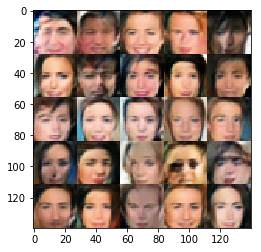

Epoch 1/1...Step 5325 Discriminator Loss: 1.4401... Generator Loss: 0.6947
Epoch 1/1...Step 5350 Discriminator Loss: 1.3384... Generator Loss: 0.8861
Epoch 1/1...Step 5375 Discriminator Loss: 1.4089... Generator Loss: 0.6762
Epoch 1/1...Step 5400 Discriminator Loss: 1.4837... Generator Loss: 0.7065


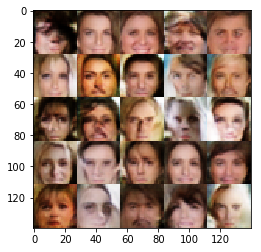

Epoch 1/1...Step 5425 Discriminator Loss: 1.4603... Generator Loss: 0.6945
Epoch 1/1...Step 5450 Discriminator Loss: 1.4541... Generator Loss: 0.7256
Epoch 1/1...Step 5475 Discriminator Loss: 1.5032... Generator Loss: 0.7257
Epoch 1/1...Step 5500 Discriminator Loss: 1.4109... Generator Loss: 0.7356


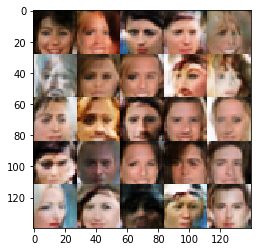

Epoch 1/1...Step 5525 Discriminator Loss: 1.3632... Generator Loss: 0.7688
Epoch 1/1...Step 5550 Discriminator Loss: 1.4318... Generator Loss: 0.6849
Epoch 1/1...Step 5575 Discriminator Loss: 1.3905... Generator Loss: 0.7445
Epoch 1/1...Step 5600 Discriminator Loss: 1.3666... Generator Loss: 0.7464


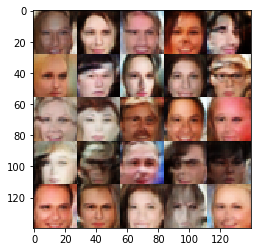

Epoch 1/1...Step 5625 Discriminator Loss: 1.3862... Generator Loss: 0.7698
Epoch 1/1...Step 5650 Discriminator Loss: 1.4253... Generator Loss: 0.8173
Epoch 1/1...Step 5675 Discriminator Loss: 1.5292... Generator Loss: 0.6670
Epoch 1/1...Step 5700 Discriminator Loss: 1.3185... Generator Loss: 0.8426


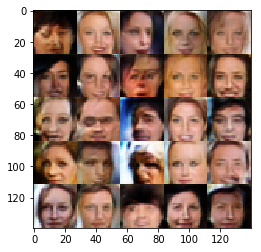

Epoch 1/1...Step 5725 Discriminator Loss: 1.4385... Generator Loss: 0.8091
Epoch 1/1...Step 5750 Discriminator Loss: 1.4137... Generator Loss: 0.8104
Epoch 1/1...Step 5775 Discriminator Loss: 1.3824... Generator Loss: 0.7046
Epoch 1/1...Step 5800 Discriminator Loss: 1.4409... Generator Loss: 0.6396


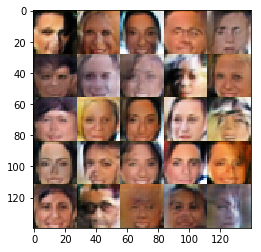

Epoch 1/1...Step 5825 Discriminator Loss: 1.5432... Generator Loss: 0.6744
Epoch 1/1...Step 5850 Discriminator Loss: 1.4342... Generator Loss: 0.7174
Epoch 1/1...Step 5875 Discriminator Loss: 1.4187... Generator Loss: 0.8205
Epoch 1/1...Step 5900 Discriminator Loss: 1.3544... Generator Loss: 0.7722


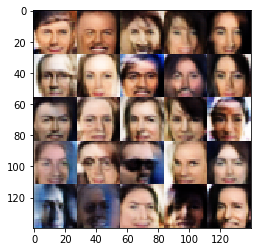

Epoch 1/1...Step 5925 Discriminator Loss: 1.4725... Generator Loss: 0.7462
Epoch 1/1...Step 5950 Discriminator Loss: 1.4088... Generator Loss: 0.7223
Epoch 1/1...Step 5975 Discriminator Loss: 1.3964... Generator Loss: 0.7069
Epoch 1/1...Step 6000 Discriminator Loss: 1.5032... Generator Loss: 0.6896


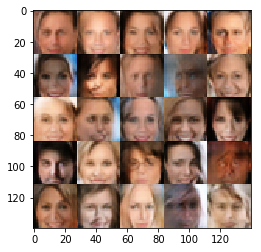

Epoch 1/1...Step 6025 Discriminator Loss: 1.4332... Generator Loss: 0.7005
Epoch 1/1...Step 6050 Discriminator Loss: 1.4447... Generator Loss: 0.7498
Epoch 1/1...Step 6075 Discriminator Loss: 1.4476... Generator Loss: 0.7737
Epoch 1/1...Step 6100 Discriminator Loss: 1.4090... Generator Loss: 0.8148


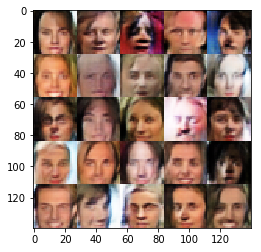

Epoch 1/1...Step 6125 Discriminator Loss: 1.5082... Generator Loss: 0.6927
Epoch 1/1...Step 6150 Discriminator Loss: 1.3965... Generator Loss: 0.7671
Epoch 1/1...Step 6175 Discriminator Loss: 1.4470... Generator Loss: 0.7746
Epoch 1/1...Step 6200 Discriminator Loss: 1.3635... Generator Loss: 0.7748


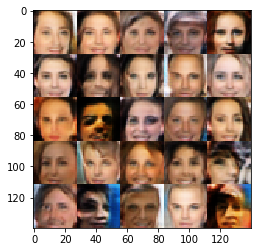

Epoch 1/1...Step 6225 Discriminator Loss: 1.4189... Generator Loss: 0.7917
Epoch 1/1...Step 6250 Discriminator Loss: 1.4741... Generator Loss: 0.7298
Epoch 1/1...Step 6275 Discriminator Loss: 1.3343... Generator Loss: 0.8068
Epoch 1/1...Step 6300 Discriminator Loss: 1.4979... Generator Loss: 0.7095


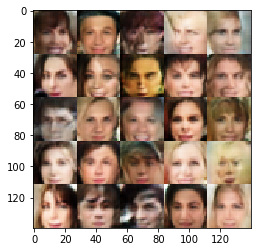

Epoch 1/1...Step 6325 Discriminator Loss: 1.4573... Generator Loss: 0.7119


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.